<a href="https://colab.research.google.com/github/sdewhitt/Market-Anomaly-Detection/blob/main/Financial_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
from pandas.errors import SettingWithCopyWarning
import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

! pip install groq --quiet
from groq import Groq

from google.colab import userdata
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

import numpy as np

#**Load data sheets**

In [5]:
data_path = '/content/drive/MyDrive/Colab Notebooks/FinancialMarketData.xlsx'
download = pd.read_excel(data_path, sheet_name="Download")
metadata = pd.read_excel(data_path, sheet_name="Metadata")
ews = pd.read_excel(data_path, sheet_name="EWS")
ews.rename(columns={'Data': 'Date'}, inplace=True)

In [ ]:
download

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59
0,EURUSDV3M Index,NaN,NaN,"Fixed Income, MM & Interbank",NaN,NaN,NaN,NaN,NaN,NaN,...,Treasury,Gold,Brent,S&P,Eurostoxx,Nasdaq,EM,Japan,2Y Ger,2Y US
1,NaN,NaN,Show/Hide data,S,H,H,H,H,H,H,...,H,H,H,H,H,H,H,H,H,H
2,676,NaN,Name,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,Index Currency,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,Ticker,XAU BGNL Curncy,ECSURPUS Index,BDIY Index,CRY Index,DXY Curncy,JPY Curncy,GBP Curncy,...,TY1 Comdty,GC1 Comdty,CO1 Comdty,ES1 Index,VG1 Index,NQ1 Index,LLL1 Index,TP1 Index,DU1 Comdty,TU2 Comdty
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1149,NaN,NaN,2021-03-23 00:00:00,1727.96,0.339,2271,184.5022,92.336,108.72,1.376,...,131.921875,1725.1,60.79,3899.8,3773,13006.25,1103.6,1958.5,112.14,110.382812
1150,NaN,NaN,2021-03-30 00:00:00,1685.56,0.303,2103,184.8741,93.297,110.29,1.3719,...,131.1875,1683.9,64.14,3947.7,3872,12878.25,1103.6,1978,112.09,110.386719
1151,NaN,NaN,2021-04-06 00:00:00,1743.28,0.44,2092,185.8393,92.335,109.88,1.3822,...,131.6875,1741.5,62.74,4064,3920,13570,1103.6,1955,112.12,110.28125
1152,NaN,NaN,2021-04-13 00:00:00,1742.69,0.467,2140,188.1368,91.852,109.19,1.3737,...,132.078125,1746.2,63.67,4132.8,3917,13975.75,1103.6,1961.5,112.115,110.292969


In [ ]:
metadata

,In order to understand the business nature of these data:,Unnamed: 1,Unnamed: 2
0,1) Look below Table 1 for the features,NaN,NaN
1,"2) Alternatively/in addition, Google the strin...",NaN,NaN
2,NaN,NaN,NaN
3,Note,NaN,NaN
4,"What you find in the sheet ""DownloadBLB"" is a ...",NaN,NaN
5,NaN,NaN,NaN
6,Response variable,NaN,NaN
7,Y,"manually tagged: Y=1 if abnormal risk/crisis, ...",NaN
8,Features,NaN,NaN
9,Table 1,NaN,NaN


In [5]:
ews

,Y,Date,XAU BGNL,ECSURPUS,BDIY,CRY,DXY,JPY,GBP,Cl1,...,LP01TREU,EMUSTRUU,LF94TRUU,MXUS,MXEU,MXJP,MXBR,MXRU,MXIN,MXCN
0,0,2000-01-11,283.25,0.077,1388,157.2600,100.560,105.86,1.6460,25.77,...,116.4635,230.5267,123.7616,1416.12,127.75,990.59,856.76,224.33,217.34,34.30
1,0,2000-01-18,287.65,0.043,1405,165.0100,101.860,105.47,1.6383,28.85,...,117.2674,231.3770,123.7616,1428.79,129.50,993.98,925.22,234.37,227.08,32.74
2,0,2000-01-25,287.15,0.135,1368,167.2400,102.410,106.04,1.6496,28.28,...,117.9946,232.3895,123.7616,1385.93,126.48,974.83,886.93,216.82,233.00,32.46
3,0,2000-02-01,282.75,0.191,1311,166.8500,104.920,107.85,1.6106,28.22,...,120.5100,231.9417,122.3281,1385.31,129.19,1007.12,842.60,201.89,237.48,31.29
4,1,2000-02-08,298.40,0.312,1277,165.4300,104.220,109.30,1.6108,28.02,...,118.7914,237.8117,122.3281,1411.95,134.67,1034.58,945.15,218.00,258.02,31.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,0,2021-03-23,1727.96,0.339,2271,184.5022,92.336,108.72,1.3760,57.76,...,427.7972,1249.4030,389.8500,3800.77,140.32,1199.57,1671.73,681.21,1695.96,110.83
1107,0,2021-03-30,1685.56,0.303,2103,184.8741,93.297,110.29,1.3719,60.55,...,428.6578,1242.2640,385.8145,3835.96,142.76,1206.29,1635.57,693.38,1690.76,108.80
1108,0,2021-04-06,1743.28,0.440,2092,185.8393,92.335,109.88,1.3822,59.33,...,430.6649,1250.2560,390.6819,3955.16,144.13,1194.62,1689.62,673.20,1689.48,111.92
1109,0,2021-04-13,1742.69,0.467,2140,188.1368,91.852,109.19,1.3737,60.18,...,430.4087,1252.5630,390.3848,4027.05,144.23,1197.06,1680.82,680.23,1672.46,108.40


# **Find Appropriate Features**

In [6]:

client = Groq(
  api_key=userdata.get("GROQ_API_KEY")
)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 2.7 MB/s eta 0:00:00


In [ ]:
system_prompt = f"""
You are a machine learning + financial expert that is helping me work on building a financial anomaly detection model.
I need to understand the data that was provided to me.
Please tell me the most important features, bonds, financial indicators, etc. for the anomaly detection model based on the given data.
"""

prompt = f'EWS sheet: {ews.head(30).to_string()}'

llm_response = client.chat.completions.create(
    model="llama-3.1-70b-versatile",
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": prompt}
    ]
)

response = llm_response.choices[0].message.content
#print(response)

Based on the provided data, here are the most important features, stocks, bonds, financial indicators, etc. for the anomaly detection model:

### Features:

1. **DXY (US Dollar Index)**: This is a benchmark index that measures the performance of the United States dollar against a basket of foreign currencies.
2. **VIX (Chicago Board Options Exchange Volatility Index)**: This is a measure of market volatility, often referred to as the "fear index".
3. **USGG30YR (30-Year US Treasury Bond Yield)**: This is a benchmark interest rate that reflects the yield on 30-year US Treasury bonds.
4. **USGG2YR (2-Year US Treasury Bond Yield)**: This is another benchmark interest rate that reflects the yield on 2-year US Treasury bonds.
5. **EC SURPUS (European Central Bank Surplus)**: This is a measure of the European Central Bank's surplus, which can impact market sentiment and interest rates.
6. **XAU (Gold Price)**: This is the price of gold, often considered a safe-haven asset and a hedge against inflation.
7. **BDIY (Baltic Dry Index)**: This is a measure of the price of shipping dry bulk commodities, which can impact global trade and economic activity.
8. **JPY (Japanese Yen Exchange Rate)**: This is the exchange rate between the US dollar and the Japanese yen, which can impact trade and investment between the two countries.
9. **GBP (British Pound Exchange Rate)**: This is the exchange rate between the US dollar and the British pound, which can impact trade and investment between the two countries.
10. **CRY (Credit Index)**: This is a measure of the creditworthiness of companies, which can impact market sentiment and interest rates.

### Stocks:

None are explicitly mentioned in the data, but the following indices can be used as proxies for stock market performance:

1. **MXUS (MSCI US Index)**: This is a benchmark index that tracks the performance of the US stock market.
2. **MXEU (MSCI Europe Index)**: This is a benchmark index that tracks the performance of the European stock market.
3. **MXJP (MSCI Japan Index)**: This is a benchmark index that tracks the performance of the Japanese stock market.
4. **MXBR (MSCI Brazil Index)**: This is a benchmark index that tracks the performance of the Brazilian stock market.
5. **MXRU (MSCI Russia Index)**: This is a benchmark index that tracks the performance of the Russian stock market.
6. **MXIN (MSCI India Index)**: This is a benchmark index that tracks the performance of the Indian stock market.
7. **MXCN (MSCI China Index)**: This is a benchmark index that tracks the performance of the Chinese stock market.

### Bonds:

1. **USGG30YR (30-Year US Treasury Bond Yield)**: This is a benchmark interest rate that reflects the yield on 30-year US Treasury bonds.
2. **USGG2YR (2-Year US Treasury Bond Yield)**: This is another benchmark interest rate that reflects the yield on 2-year US Treasury bonds.
3. **GT10 (10-Year German Bund Yield)**: This is a benchmark interest rate that reflects the yield on 10-year German government bonds.
4. **GTDEM30Y (30-Year German Bund Yield)**: This is a benchmark interest rate that reflects the yield on 30-year German government bonds.
5. **GTDEM10Y (10-Year German Bund Yield)**: This is a benchmark interest rate that reflects the yield on 10-year German government bonds.
6. **GTDEM2Y (2-Year German Bund Yield)**: This is a benchmark interest rate that reflects the yield on 2-year German government bonds.
7. **GTITL30YR (30-Year Italian Bund Yield)**: This is a benchmark interest rate that reflects the yield on 30-year Italian government bonds.
8. **GTITL10YR (10-Year Italian Bund Yield)**: This is a benchmark interest rate that reflects the yield on 10-year Italian government bonds.
9. **GTITL2YR (2-Year Italian Bund Yield)**: This is a benchmark interest rate that reflects the yield on 2-year Italian government bonds.
10. **GTJPY30YR (30-Year Japanese Government Bond Yield)**: This is a benchmark interest rate that reflects the yield on 30-year Japanese government bonds.
11. **GTJPY10YR (10-Year Japanese Government Bond Yield)**: This is a benchmark interest rate that reflects the yield on 10-year Japanese government bonds.
12. **GTJPY2YR (2-Year Japanese Government Bond Yield)**: This is a benchmark interest rate that reflects the yield on 2-year Japanese government bonds.
13. **GTGBP30Y (30-Year UK Gilt Yield)**: This is a benchmark interest rate that reflects the yield on 30-year UK government bonds.
14. **GTGBP20Y (20-Year UK Gilt Yield)**: This is a benchmark interest rate that reflects the yield on 20-year UK government bonds.
15. **GTGBP2Y (2-Year UK Gilt Yield)**: This is a benchmark interest rate that reflects the yield on 2-year UK government bonds.

### Other:

1. **EONIA (Euro OverNight Index Average)**: This is a benchmark interest rate that reflects the overnight rate in the eurozone.
2. **LUMSTRUU (Lumber Price)**: This is the price of lumber, often used as a proxy for the housing market and construction activity.
3. **LMBITR (Lumber Bit Rate)**: This is a measure of the bit rate used in lumber production, which can impact the efficiency of the industry.
4. **LUACTRUU (Lumber Actual Rate)**: This is a measure of the actual rate of lumber production, which can impact the supply of lumber.
5. **LF98TRUU (Lumber Futures Rate)**: This is a measure of the futures rate for lumber, which can impact market sentiment and prices.
6. **LG30TRUU (Lumber 30-Day Rate)**: This is a measure of the 30-day rate for lumber, which can impact market sentiment and prices.
7. **LP01TREU (Lumber 1-Year Rate)**: This is a measure of the 1-year rate for lumber, which can impact market sentiment and prices.
8. **EMUSTRUU (EMU Striking Rate)**: This is a measure of the striking rate in the eurozone, which can impact market sentiment and prices.

# **Model Training**

In [6]:
features = ['VIX', 'DXY', 'BDIY', 'XAU BGNL', 'LUMSTRUU', 'USGG30YR', 'GT10', 'GTDEM10Y', 'GTITL10YR', 'GTJPY10YR']

focused_features = ews[['Y', 'Date'] + features]

window_count = 4 # each window is about a month long. TODO: try different window sizes
for f in features: # generate moving averages
  focused_features.loc[:, f'{f}_MA'] = focused_features[f].rolling(window=window_count).mean()

  # patch up NaN values with smaller temp windows until the intended window size is met
  for i in range(window_count - 1):
    focused_features.loc[i, f'{f}_MA'] = focused_features.loc[i, f]
    focused_features.loc[i, f'{f}_MA'] = focused_features.loc[:i, f'{f}_MA'].mean()
focused_features

,Y,Date,VIX,DXY,BDIY,XAU BGNL,LUMSTRUU,USGG30YR,GT10,GTDEM10Y,...,VIX_MA,DXY_MA,BDIY_MA,XAU BGNL_MA,LUMSTRUU_MA,USGG30YR_MA,GT10_MA,GTDEM10Y_MA,GTITL10YR_MA,GTJPY10YR_MA
0,0,2000-01-11,22.50,100.560,1388,283.25,870.94,6.6710,6.657,5.541,...,22.500000,100.560000,1388.000000,283.250000,870.9400,6.671000,6.657000,5.54100,5.77700,1.709000
1,0,2000-01-18,21.50,101.860,1405,287.65,869.33,6.7470,6.748,5.644,...,22.000000,101.210000,1396.500000,285.450000,870.1350,6.709000,6.702500,5.59250,5.83300,1.737000
2,0,2000-01-25,23.02,102.410,1368,287.15,873.50,6.6340,6.692,5.515,...,22.506667,101.393333,1384.166667,285.283333,871.5250,6.671333,6.683833,5.54950,5.79000,1.690333
3,0,2000-02-01,23.45,104.920,1311,282.75,871.22,6.4230,6.619,5.459,...,22.617500,102.437500,1368.000000,285.200000,871.2475,6.618750,6.679000,5.53975,5.78400,1.717250
4,1,2000-02-08,21.25,104.220,1277,298.40,872.39,6.2310,6.613,5.482,...,22.305000,103.352500,1340.250000,288.987500,871.6100,6.508750,6.668000,5.52500,5.77175,1.769750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,0,2021-03-23,20.30,92.336,2271,1727.96,2301.89,2.3264,1.622,-0.343,...,22.055000,91.736000,1965.500000,1727.657500,2306.4975,2.282425,1.540750,-0.33350,0.64750,0.105250
1107,0,2021-03-30,19.61,93.297,2103,1685.56,2297.31,2.3687,1.706,-0.288,...,20.932500,92.364000,2073.000000,1714.850000,2302.2325,2.326775,1.619000,-0.31725,0.64875,0.095750
1108,0,2021-04-06,18.12,92.335,2092,1743.28,2302.52,2.3230,1.658,-0.317,...,19.455000,92.458250,2120.750000,1721.495000,2300.9325,2.349150,1.651500,-0.32125,0.64875,0.092500
1109,0,2021-04-13,16.65,91.852,2140,1742.69,2309.15,2.2939,1.616,-0.293,...,18.670000,92.455000,2151.500000,1724.872500,2302.7175,2.328000,1.650500,-0.31025,0.67975,0.092750


In [31]:
X = focused_features.iloc[:, 2:]
y_true = focused_features.iloc[:, 0]
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE # trying to over sample for 1s

# Example dataset
# Assuming `X` is your features and `y_true` contains the actual anomaly labels (1 for anomaly, 0 for normal)
# Replace with your actual dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y_true)


# Train Isolation Forest
model = IsolationForest(contamination=0.213, random_state=42)
model.fit(X_resampled)

# Predict anomalies
anomaly_scores = model.decision_function(X_scaled)  # Anomaly scores (higher = normal, lower = anomalous)
anomaly_labels = model.predict(X_scaled)            # Predicted labels (-1 = anomaly, 1 = normal)

# Adjust Isolation Forest labels to match your labeling convention (e.g., 1 = anomaly, 0 = normal)
anomaly_labels = [0 if label == 1 else 1 for label in anomaly_labels]

# Add results to the DataFrame
focused_features.loc[:, 'anomaly_score'] = pd.Series(anomaly_scores)
focused_features.loc[:, 'anomaly_labels'] = pd.Series(anomaly_labels)

# Evaluate the model (requires ground truth labels `y_true`)
print(classification_report(y_true, anomaly_labels))
roc_auc = roc_auc_score(y_true, anomaly_scores)
print(f"ROC-AUC Score: {roc_auc}")


              precision    recall  f1-score   support

           0       0.82      0.86      0.84       874
           1       0.36      0.29      0.32       237

    accuracy                           0.74      1111
   macro avg       0.59      0.57      0.58      1111
weighted avg       0.72      0.74      0.73      1111

ROC-AUC Score: 0.4219892052641234


In [11]:
print(pd.Series(anomaly_labels).value_counts())
print(focused_features['Y'].value_counts())

0    874
1    237
Name: count, dtype: int64
Y
0    874
1    237
Name: count, dtype: int64


In [65]:
focused_features['anomaly_score']

,anomaly_score
0,-0.009251
1,-0.009597
2,-0.008526
3,-0.043326
4,-0.042909
...,...
1106,-0.026495
1107,-0.025456
1108,-0.023999
1109,-0.023820


In [68]:
threshold = -0.01  # Adjust this threshold based on your data and desired precision
focused_features.loc[:, 'crash_prediction'] = np.where(focused_features['anomaly_score'] < threshold, 1, 0)  # 1 for crash, 0 for no crash
focused_features.loc[:, 'crash_prediction'].value_counts()
# crash_prediction seems to be inaccurate

,count
crash_prediction,
0,953
1,158


In [69]:
#predicted_anomaly_dates = focused_features.loc[focused_features['crash_prediction'] == 1, 'Date']
predicted_anomaly_dates = focused_features.loc[focused_features['anomaly_labels'] == -1, 'Date']
actual_anomaly_dates = focused_features.loc[focused_features['Y'] == 1, 'Date']
date_matches = predicted_anomaly_dates.isin(actual_anomaly_dates)
date_matches.value_counts()

,count
Date,
False,121
True,116


# PCA

[0 0 0 ... 0 0 0]


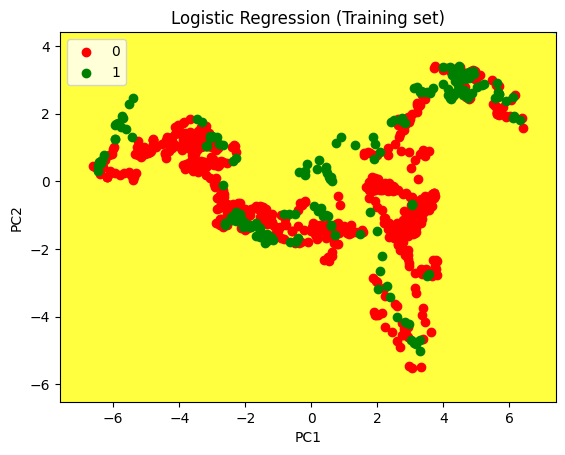

In [7]:
#def do_PCA(f):
f = 0
X = focused_features.iloc[:, 2:21].values
y = focused_features.iloc[:, f].values
print(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

pca = PCA(n_components=2)

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

explained_variance = pca.explained_variance_ratio_

classifier = LogisticRegression(random_state=0)
classifier.fit(X_train, y_train)

# Predicting the test set result using
# predict function under LogisticRegression
y_pred = classifier.predict(X_test)

# making confusion matrix between
#  test set of Y and predicted value.
cm = confusion_matrix(y_test, y_pred)

# Predicting the training set
# result through scatter plot
from matplotlib.colors import ListedColormap

X_set, y_set = X_train, y_train
X1, X2 = np.meshgrid(np.arange(start=X_set[:, 0].min() - 1,
                               stop=X_set[:, 0].max() + 1, step=0.01),
                     np.arange(start=X_set[:, 1].min() - 1,
                               stop=X_set[:, 1].max() + 1, step=0.01))

plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(),
                                                  X2.ravel()]).T).reshape(X1.shape), alpha=0.75,
             cmap=ListedColormap(('yellow', 'white', 'aquamarine')))

plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                color=ListedColormap(('red', 'green', 'blue'))(i), label=j)

plt.title('Logistic Regression')
plt.xlabel('PC1')  # for Xlabel
plt.ylabel('PC2')  # for Ylabel
plt.legend()  # to show legend

# show scatter plot
plt.show()


In [111]:
#do_PCA(features[0])